In [1]:
# 代码块1：数据读取 & 目标转三分类（数据集3；目标=Number of Doctors Visited）
import os
from pathlib import Path
import pandas as pd
import numpy as np

# ===== 路径与配置 =====
# 使用相对路径，适配GitHub部署
# 假设数据集文件在项目根目录的 data/ 文件夹中
PROJECT_ROOT = Path.cwd()  # 当前工作目录（项目根目录）
DATA_PATH = PROJECT_ROOT / "data" / "数据集3.xlsx"  # 数据集路径

# 如果 data/ 目录不存在，尝试直接在根目录查找
if not DATA_PATH.exists():
    DATA_PATH = PROJECT_ROOT / "数据集3.xlsx"

TARGET_COL = "Number of Doctors Visited"

# 输出目录放在项目根目录的 output/ 文件夹中
OUTPUT_DIR = PROJECT_ROOT / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ===== 读数据 =====
# 检查数据文件是否存在
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"数据集文件未找到！\n"
        f"请确保 '数据集3.xlsx' 文件位于以下位置之一：\n"
        f"  1. {PROJECT_ROOT / 'data' / '数据集3.xlsx'}\n"
        f"  2. {PROJECT_ROOT / '数据集3.xlsx'}\n"
        f"当前工作目录: {PROJECT_ROOT}"
    )

print(f"✅ 正在读取数据集: {DATA_PATH}")
df = pd.read_excel(DATA_PATH, engine="openpyxl")
assert TARGET_COL in df.columns, f"未找到目标列 {TARGET_COL}"

y_raw = df[TARGET_COL]

# —— 将目标稳健地转为三分类标签 0/1/2 —— #
def to_three_class(s: pd.Series, name: str):
    # 若本列是非数值，且不同取值数==3：直接 factorize 成 0/1/2
    if not pd.api.types.is_numeric_dtype(s):
        vals = s.astype(str).str.strip()
        uniq = vals.dropna().unique().tolist()
        if len(uniq) == 3:
            codes, uniques = pd.factorize(vals, sort=False)
            mapping = {u: i for i, u in enumerate(uniques)}
            print(f"✅ 目标列为三类（非数值）：映射 {mapping}")
            return pd.Series(codes, index=s.index, name=name).astype(int), {"type":"categorical", "mapping":mapping}
        # 尝试转数值再处理
        s = pd.to_numeric(vals, errors="coerce")

    # 此时 s 应为数值或 NaN
    s_num = pd.to_numeric(s, errors="coerce")
    # 缺失用中位数填（影响很小，仅用于切分）
    if s_num.isna().any():
        med = float(np.nanmedian(s_num))
        s_num = s_num.fillna(med)

    uniq_num = np.unique(s_num)
    if len(uniq_num) == 3:
        # 直接把 3 个唯一值按升序映射为 0/1/2
        order = np.sort(uniq_num)
        mapping = {order[i]: i for i in range(3)}
        y3 = s_num.map(mapping).astype(int)
        print(f"✅ 目标列为三类（数值型三个唯一值）：升序映射 {mapping}")
        return y3.rename(name), {"type":"numeric-3-unique", "mapping": mapping}
    else:
        # 用等频分箱 qcut 切成三类（0低/1中/2高）
        q = pd.qcut(s_num, q=3, duplicates='drop')
        # 如果分位冲突导致少于3箱，退化为按等宽分箱
        if q.nunique() < 3:
            bins = np.linspace(s_num.min(), s_num.max(), 4)  # 3 bins → 4 edges
            q = pd.cut(s_num, bins=bins, include_lowest=True)
        codes = q.cat.codes  # -1 表示缺失/异常箱
        # 把 -1 用最频繁的类别填
        if (codes == -1).any():
            mode_code = int(pd.Series(codes[codes != -1]).mode().iloc[0])
            codes = codes.replace(-1, mode_code)
        y3 = codes.astype(int).rename(name)
        # 记录区间
        cats = q.cat.categories
        print("✅ 三分位切分区间：")
        for i, c in enumerate(cats):
            cnt = int((y3 == i).sum())
            print(f"  类别{i}: 区间={c}, 数量={cnt}, 占比={cnt/len(y3):.3f}")
        return y3, {"type":"qcut", "bins": [str(c) for c in cats]}

y, y_meta = to_three_class(y_raw, TARGET_COL)

# 特征
X = df.drop(columns=[TARGET_COL])

# 数值/类别特征识别
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"✅ 数据维度: {df.shape}")
print(f"目标列: {TARGET_COL}（三分类0/1/2） | 类别分布: " +
      ", ".join([f"{i}:{(y==i).mean():.3f}" for i in sorted(y.unique())]))
display(df.head(3))


✅ 正在读取数据集: C:\Users\20855\数据集3.xlsx
✅ 目标列为三类（数值型三个唯一值）：升序映射 {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2}
✅ 数据维度: (714, 15)
目标列: Number of Doctors Visited（三分类0/1/2） | 类别分布: 0:0.183, 1:0.521, 2:0.296


,Number of Doctors Visited,Age,Phyiscal Health,Mental Health,Dental Health,Employment,Stress Keeps Patient from Sleeping,Medication Keeps Patient from Sleeping,Pain Keeps Patient from Sleeping,Bathroom Needs Keeps Patient from Sleeping,Uknown Keeps Patient from Sleeping,Trouble Sleeping,Prescription Sleep Medication,Race,Gender
0,3,2,4,3,3,3,0,0,0,0,1,2,3,1,2
1,2,2,4,2,3,3,1,0,0,1,0,3,3,1,1
2,3,2,3,2,3,3,0,0,0,0,1,3,3,4,1


,Missing ratio
Number of Doctors Visited,0.0
Age,0.0
Phyiscal Health,0.0
Mental Health,0.0
Dental Health,0.0
Employment,0.0
Stress Keeps Patient from Sleeping,0.0
Medication Keeps Patient from Sleeping,0.0
Pain Keeps Patient from Sleeping,0.0
Bathroom Needs Keeps Patient from Sleeping,0.0


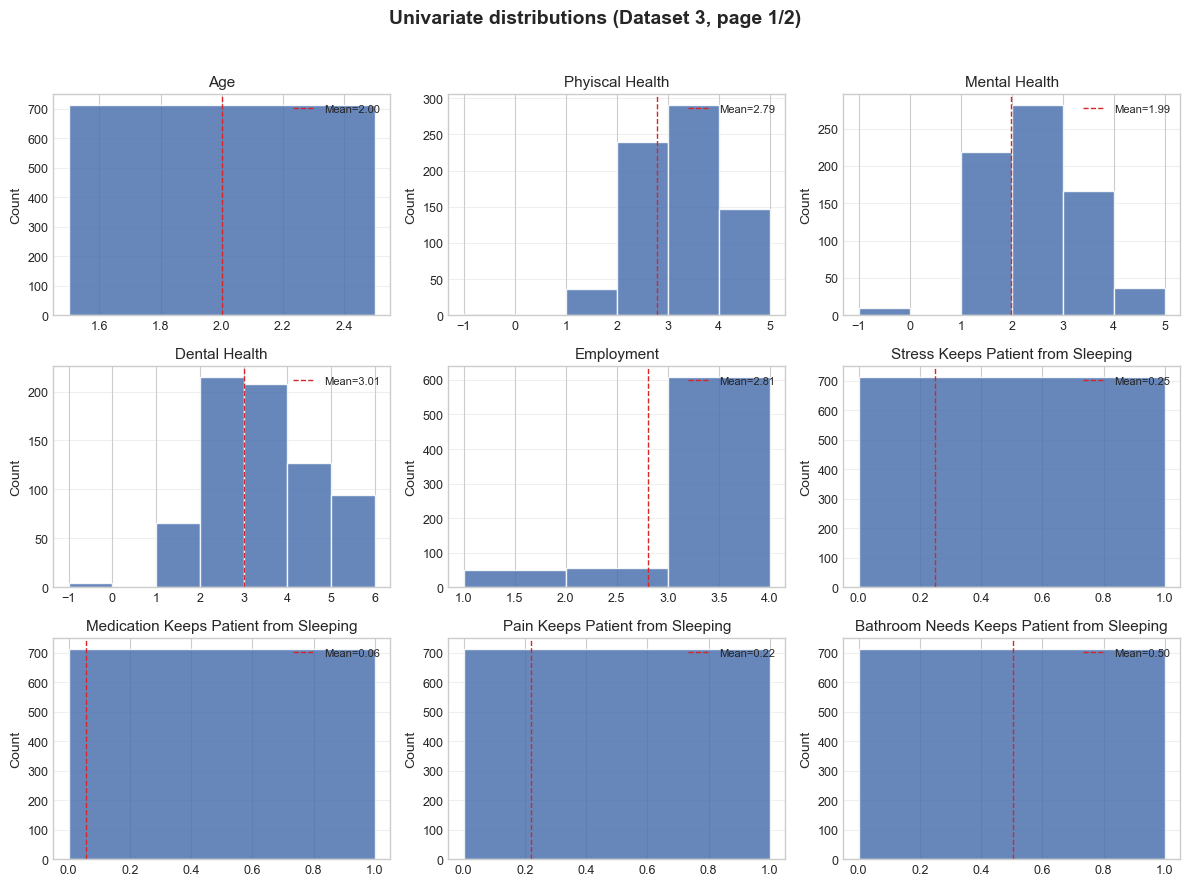

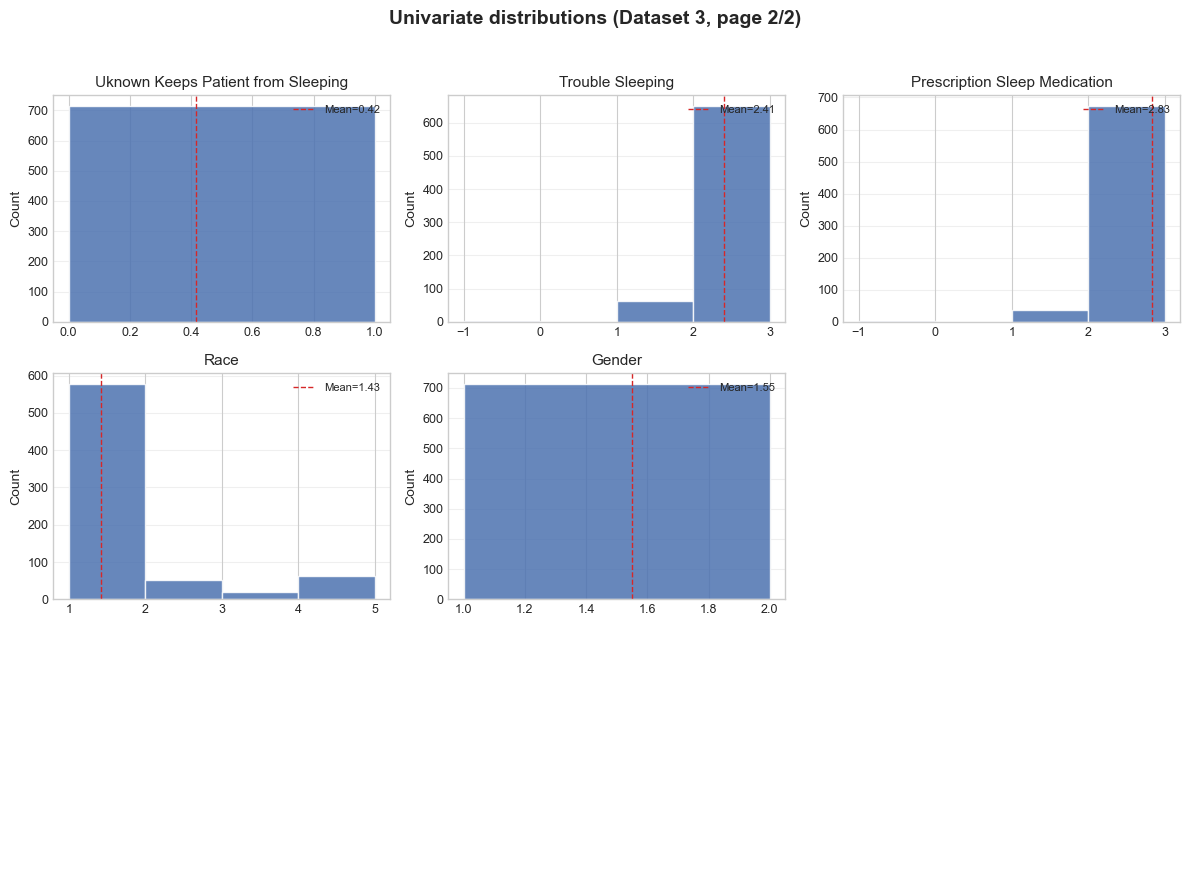

✅ EDA 图已保存。


In [2]:
# 代码块2：EDA - 缺失值 & 单变量分布（美化版，3×3 自动分页）
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

for v in ["df", "X", "y", "num_cols", "cat_cols", "OUTPUT_DIR", "TARGET_COL"]:
    assert v in locals(), f"变量 {v} 不存在，请先运行代码块1。"

try:
    plt.style.use("seaborn-v0_8-whitegrid")
except Exception:
    plt.style.use("seaborn-whitegrid")

plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

# 1) 缺失值汇总
na_summary = df.isna().mean().sort_values(ascending=False).rename("Missing ratio")
display(na_summary.head(20).to_frame())
na_summary.to_csv(OUTPUT_DIR / "missing_summary_ds3.csv", encoding="utf-8-sig")

# 2) 单变量分布
cols_all, per_page = (num_cols + cat_cols), 9
pages = math.ceil(len(cols_all)/per_page)

def _save_show(fig, path):
    fig.tight_layout(rect=[0,0,1,0.96])
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.show(); plt.close(fig)

for p in range(pages):
    sub = cols_all[p*per_page:(p+1)*per_page]
    fig, axes = plt.subplots(3,3, figsize=(12,9)); axes = axes.ravel()
    fig.suptitle(f"Univariate distributions (Dataset 3, page {p+1}/{pages})", fontsize=14, fontweight="bold")

    for i, c in enumerate(sub):
        ax = axes[i]
        if c in num_cols:
            s = pd.to_numeric(df[c], errors="coerce").dropna()
            if len(s)==0:
                ax.text(0.5,0.5,"No valid numeric values",ha="center",va="center"); ax.set_axis_off()
            else:
                ax.hist(s, bins="auto", color="#4C72B0", edgecolor="white", alpha=0.85)
                mu = s.mean()
                ax.axvline(mu, color="#D62728", linestyle="--", linewidth=1.0, label=f"Mean={mu:.2f}")
                ax.legend(fontsize=8, loc="upper right")
                ax.set_ylabel("Count"); ax.set_xlabel("")
                ax.grid(True, axis="y", alpha=0.3)
            ax.set_title(c)
        else:
            vc = df[c].astype("category").value_counts(dropna=False).head(12)
            if vc.empty:
                ax.text(0.5,0.5,"No categorical values",ha="center",va="center"); ax.set_axis_off()
            else:
                y_pos = np.arange(len(vc))
                ax.barh(y_pos, vc.values, color="#55A868", alpha=0.9)
                ax.set_yticks(y_pos); ax.set_yticklabels([str(k) for k in vc.index])
                ax.invert_yaxis(); ax.set_xlabel("Count"); ax.grid(True, axis="x", alpha=0.3)
                ax.set_title(c)

    for j in range(len(sub), 9): axes[j].set_axis_off()
    _save_show(fig, OUTPUT_DIR / f"univariate_page_{p+1}_ds3.png")

print("✅ EDA 图已保存。")


In [3]:
# 代码块3：数据切分 + 预处理（全部特征；三分类）
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print(f"✅ 训练集: {X_train.shape}, 测试集: {X_test.shape}")
print("类分布(Train):", pd.Series(y_train).value_counts(normalize=True).sort_index().round(3).to_dict())
print("类分布(Test): ", pd.Series(y_test).value_counts(normalize=True).sort_index().round(3).to_dict())

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_full = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=True
)

_ = preprocessor_full.fit(X_train)
feature_names_after = preprocessor_full.get_feature_names_out().tolist()
print(f"变换后特征数: {len(feature_names_after)}  示例: {feature_names_after[:5]}")


✅ 训练集: (571, 14), 测试集: (143, 14)
类分布(Train): {0: 0.184, 1: 0.52, 2: 0.296}
类分布(Test):  {0: 0.182, 1: 0.524, 2: 0.294}
变换后特征数: 14  示例: ['num__Age', 'num__Phyiscal Health', 'num__Mental Health', 'num__Dental Health', 'num__Employment']


In [4]:
# 代码块4：不做特征筛选，直接使用全部特征
import pandas as pd

for v in ["num_cols", "cat_cols", "preprocessor_full"]:
    assert v in locals(), f"变量 {v} 不存在，请先运行代码块1~3。"

selected_features = num_cols + cat_cols
display(pd.DataFrame({"selected_features": selected_features}))
pipe_fs = preprocessor_full
print("✅ 使用全部特征。")


,selected_features
0,Age
1,Phyiscal Health
2,Mental Health
3,Dental Health
4,Employment
5,Stress Keeps Patient from Sleeping
6,Medication Keeps Patient from Sleeping
7,Pain Keeps Patient from Sleeping
8,Bathroom Needs Keeps Patient from Sleeping
9,Uknown Keeps Patient from Sleeping


✅ 使用全部特征。


Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ RF 测试集指标： {'Model': 'RF', 'Accuracy': 0.5384615384615384, 'F1_macro': 0.26218776916451336, 'F1_micro': 0.5384615384615384, 'F1_weighted': 0.39202038271805717, 'ROC_AUC_macro': 0.613792556919657, 'ROC_AUC_micro': 0.7048999951097854, 'PR_AUC_macro': 0.4469440439685513}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ DT 测试集指标： {'Model': 'DT', 'Accuracy': 0.5454545454545454, 'F1_macro': 0.31129772483155943, 'F1_micro': 0.5454545454545454, 'F1_weighted': 0.4332891988394381, 'ROC_AUC_macro': 0.6038982806589545, 'ROC_AUC_micro': 0.7009144701452394, 'PR_AUC_macro': 0.4029774152841718}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ KNN 测试集指标： {'Model': 'KNN', 'Accuracy': 0.46153846153846156, 'F1_macro': 0.29521016617790813, 'F1_micro': 0.46153846153846156, 'F1_weighted': 0.4015544572729323, 'ROC_AUC_macro': 0.5024408550695455, 'ROC_AUC_micro': 0.6415228128514843, 'PR_AUC_macro': 0.3650743160858423}


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


✅ LR 测试集指标： {'Model': 'LR', 'Accuracy': 0.5454545454545454, 'F1_macro': 0.3311710481392967, 'F1_micro': 0.5454545454545454, 'F1_weighted': 0.44945529035662196, 'ROC_AUC_macro': 0.6374586029202758, 'ROC_AUC_micro': 0.7235806151890067, 'PR_AUC_macro': 0.4628700596026567}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ ANN 测试集指标： {'Model': 'ANN', 'Accuracy': 0.5454545454545454, 'F1_macro': 0.3311710481392967, 'F1_micro': 0.5454545454545454, 'F1_weighted': 0.44945529035662196, 'ROC_AUC_macro': 0.5829177221171308, 'ROC_AUC_micro': 0.6976135752359529, 'PR_AUC_macro': 0.42451718893547197}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ XGB 测试集指标： {'Model': 'XGB', 'Accuracy': 0.5594405594405595, 'F1_macro': 0.3160446570972887, 'F1_micro': 0.5594405594405595, 'F1_weighted': 0.4418884464817479, 'ROC_AUC_macro': 0.6041652409070983, 'ROC_AUC_micro': 0.7106459973592841, 'PR_AUC_macro': 0.4532111451544633}


,Model,Accuracy,F1_macro,F1_micro,F1_weighted,ROC_AUC_macro,ROC_AUC_micro,PR_AUC_macro
3,LR,0.545455,0.331171,0.545455,0.449455,0.637459,0.723581,0.462870
0,RF,0.538462,0.262188,0.538462,0.392020,0.613793,0.704900,0.446944
5,XGB,0.559441,0.316045,0.559441,0.441888,0.604165,0.710646,0.453211
1,DT,0.545455,0.311298,0.545455,0.433289,0.603898,0.700914,0.402977
4,ANN,0.545455,0.331171,0.545455,0.449455,0.582918,0.697614,0.424517
2,KNN,0.461538,0.295210,0.461538,0.401554,0.502441,0.641523,0.365074


🏆 最佳模型：LR | Macro ROC-AUC=0.6375


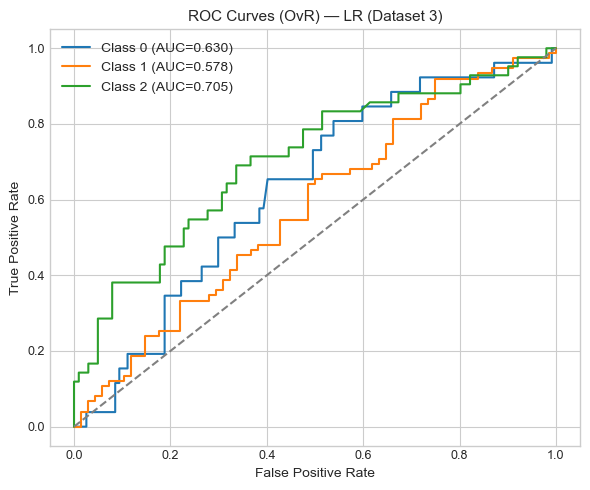

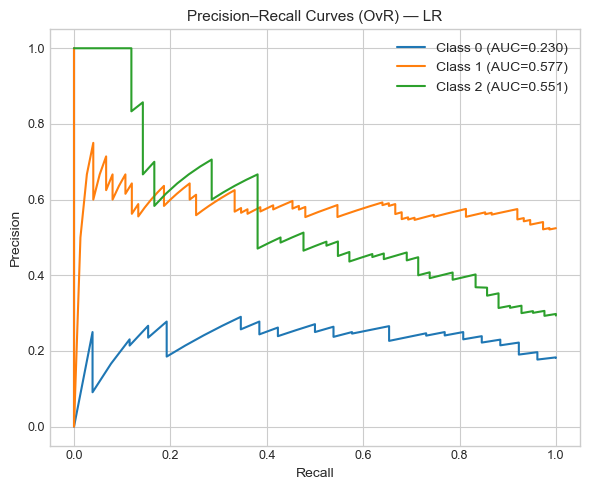

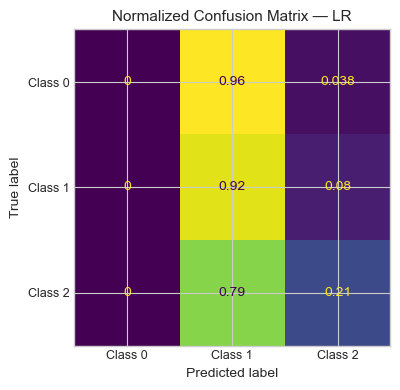

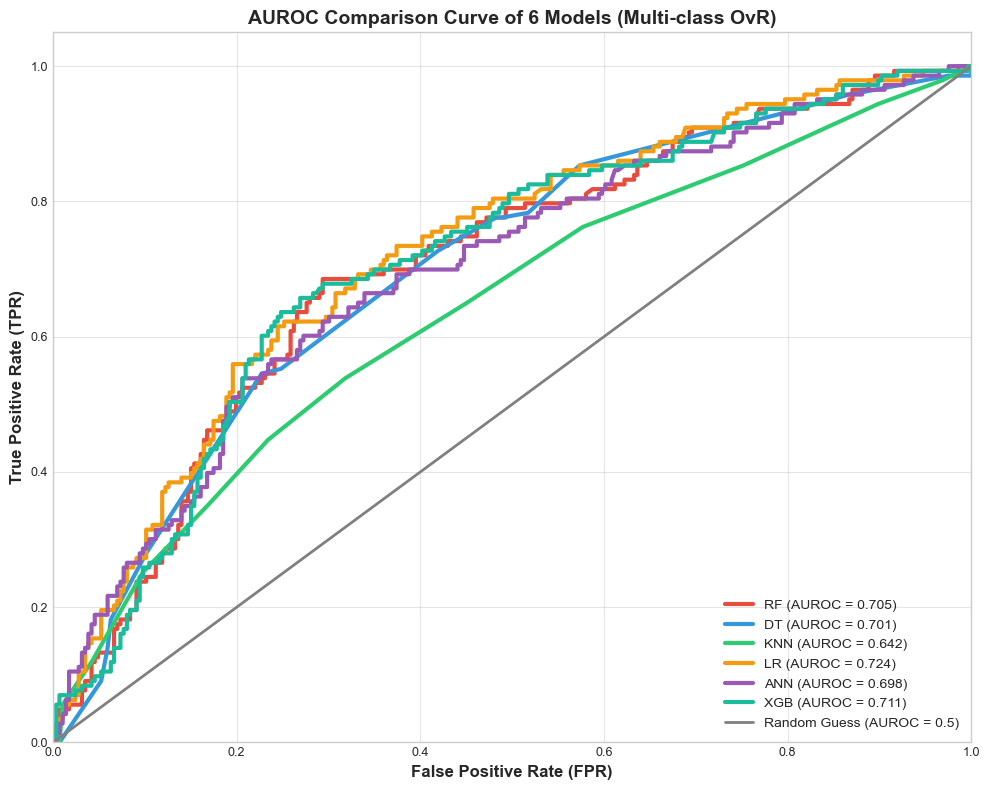

In [5]:
# 代码块5：六模型超参搜索 + 多分类评估（OvR ROC/PR、混淆矩阵）
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import joblib

# ===== 前置检查 =====
for v in ["pipe_fs", "X_train", "X_test", "y_train", "y_test", "selected_features", "OUTPUT_DIR", "RANDOM_STATE"]:
    assert v in locals(), f"变量 {v} 不存在，请先运行代码块1~4。"

classes = np.sort(pd.Series(y).unique())
n_classes = len(classes)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def make_pipe(estimator):
    return Pipeline([("pre", pipe_fs), ("clf", estimator)])

param_spaces = {
    "RF": (RandomForestClassifier(random_state=RANDOM_STATE),
           {"clf__n_estimators":[200,400,600], "clf__max_depth":[None,4,8,12],
            "clf__min_samples_split":[2,5,10], "clf__min_samples_leaf":[1,2,4],
            "clf__max_features":["sqrt","log2",None]}),
    "DT": (DecisionTreeClassifier(random_state=RANDOM_STATE),
           {"clf__max_depth":[None,3,5,7,10], "clf__min_samples_split":[2,5,10,20],
            "clf__min_samples_leaf":[1,2,4,8], "clf__criterion":["gini","entropy","log_loss"]}),
    "KNN": (KNeighborsClassifier(),
            {"clf__n_neighbors":list(range(3,31,2)), "clf__weights":["uniform","distance"], "clf__p":[1,2]}),
    "LR": (LogisticRegression(max_iter=3000, solver="lbfgs"),
           {"clf__C":np.logspace(-3,2,10), "clf__penalty":["l2"]}),
    "ANN": (MLPClassifier(max_iter=800, random_state=RANDOM_STATE,early_stopping=True,  
        validation_fraction=0.1, 
        n_iter_no_change=10),  
            {"clf__hidden_layer_sizes":[(64,),(128,),(64,32)], "clf__alpha":np.logspace(-5,-1,5),
             "clf__learning_rate_init":[1e-4,3e-4,1e-3]}),
    "XGB": (XGBClassifier(
                n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1,
                eval_metric="mlogloss", objective="multi:softprob", num_class=n_classes),
            {"clf__max_depth":[3,4,5,6], "clf__learning_rate":[0.01,0.03,0.1],
             "clf__subsample":[0.7,0.8,1.0], "clf__colsample_bytree":[0.7,0.8,1.0],
             "clf__reg_lambda":[0.5,1.0,2.0]})
}

leaderboard, best_auc, final_pipe, final_name = [], -np.inf, None, None
Y_test_bin = label_binarize(y_test, classes=classes)

# ==== 六模型循环 ====
model_probas = []
for name, (est, space) in param_spaces.items():
    pipe = make_pipe(est)
    from itertools import product
    param_combinations = len(list(product(*space.values())))
    n_iter = min(25, param_combinations)
    rscv = RandomizedSearchCV(pipe, space, n_iter=n_iter, scoring="roc_auc_ovr", cv=skf,
                              n_jobs=-1, random_state=RANDOM_STATE, refit=True, verbose=1)
    rscv.fit(X_train[selected_features], y_train)
    best_model = rscv.best_estimator_
    
    if hasattr(best_model, 'predict_proba'):
        proba = best_model.predict_proba(X_test[selected_features])
        model_probas.append((name, proba))  # 存入列表
    else:
        print(f"模型 {name} 不支持 predict_proba，跳过AUROC绘图")
        continue

    proba = best_model.predict_proba(X_test[selected_features])
    pred = proba.argmax(axis=1)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "F1_macro": f1_score(y_test, pred, average="macro"),
        "F1_micro": f1_score(y_test, pred, average="micro"),
        "F1_weighted": f1_score(y_test, pred, average="weighted"),
        "ROC_AUC_macro": roc_auc_score(Y_test_bin, proba, average="macro", multi_class="ovr"),
        "ROC_AUC_micro": roc_auc_score(Y_test_bin, proba, average="micro", multi_class="ovr"),
        "PR_AUC_macro": average_precision_score(Y_test_bin, proba, average="macro")
    }
    leaderboard.append(metrics)
    print(f"✅ {name} 测试集指标：", metrics)

    if metrics["ROC_AUC_macro"] > best_auc:
        best_auc, final_pipe, final_name = metrics["ROC_AUC_macro"], best_model, name

lb_df = pd.DataFrame(leaderboard).sort_values("ROC_AUC_macro", ascending=False)
display(lb_df)
lb_df.to_csv(OUTPUT_DIR/"model_leaderboard_ds3.csv", index=False, encoding="utf-8-sig")
print(f"🏆 最佳模型：{final_name} | Macro ROC-AUC={best_auc:.4f}")

# ==== 绘制 ROC（OvR） ====
proba_best = final_pipe.predict_proba(X_test[selected_features])
Y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(6,5))
for k in range(n_classes):
    fpr, tpr, _ = roc_curve(Y_test_bin[:,k], proba_best[:,k])
    auc_k = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {k} (AUC={auc_k:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves (OvR) — {final_name} (Dataset 3)")
plt.legend(); plt.tight_layout()
plt.savefig(OUTPUT_DIR/"ROC_OvR_best_ds3.png", dpi=300, bbox_inches="tight")
plt.show()

# ==== 绘制 PR 曲线（手动画） ====
plt.figure(figsize=(6,5))
for k in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test_bin[:,k], proba_best[:,k])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"Class {k} (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall Curves (OvR) — {final_name}")
plt.legend(); plt.tight_layout()
plt.savefig(OUTPUT_DIR/"PR_OvR_best_ds3.png", dpi=300, bbox_inches="tight")
plt.show()

# ==== 绘制归一化混淆矩阵 ====
from sklearn.metrics import ConfusionMatrixDisplay
pred_best = proba_best.argmax(axis=1)
cm = confusion_matrix(y_test, pred_best, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=[f"Class {k}" for k in classes])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, colorbar=False)
plt.title(f"Normalized Confusion Matrix — {final_name}")
plt.tight_layout()
plt.savefig(OUTPUT_DIR/"confusion_matrix_norm_ds3.png", dpi=300, bbox_inches="tight")
plt.show()

# ========== 新增：6模型AUROC对比图（英文标识+全实线+高显眼配色） ==========
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 标签二值化（多分类适配）
classes = np.unique(y_test)
Y_test_bin = label_binarize(y_test, classes=classes)

# 设置绘图样式（英文字体）
plt.rcParams['font.family'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 8))

# 高显眼配色方案（6种高对比度颜色）
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']
# 全部改为实线，仅通过颜色区分（取消线型差异）
linestyles = ['-', '-', '-', '-', '-', '-']
linewidths = [3, 3, 3, 3, 3, 3]  # 统一加粗实线

# 循环绘制每个模型的ROC曲线（全实线）
for idx, (model_name, proba) in enumerate(model_probas):
    fpr_micro, tpr_micro, _ = roc_curve(Y_test_bin.ravel(), proba.ravel())
    auroc_micro = auc(fpr_micro, tpr_micro)
    
    plt.plot(
        fpr_micro, tpr_micro,
        color=colors[idx],
        linestyle=linestyles[idx],  # 全实线
        linewidth=linewidths[idx],
        label=f'{model_name} (AUROC = {auroc_micro:.3f})'
    )

# 随机猜测基准线也改为实线（灰色加粗，和模型曲线区分）
plt.plot([0, 1], [0, 1], color='#808080', linestyle='-', linewidth=2, label='Random Guess (AUROC = 0.5)')

# 图表样式设置（全英文）
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
plt.title('AUROC Comparison Curve of 6 Models (Multi-class OvR)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10, framealpha=0.9)
plt.grid(alpha=0.2, linestyle='-', color='gray')
plt.tight_layout()

# 保存图片
plt.savefig(f"{OUTPUT_DIR}/6models_AUROC_comparison_EN_solid.png", dpi=300, bbox_inches="tight")
plt.show()
# ========== 调整后代码结束 ==========

⚙️ 构建 SHAP Explainer...
✅ SHAP 计算完成: (143, 14, 3), base_values per class = [-0.56225869  0.57859526 -0.01633657]

🎨 绘制 Class 0 的 SHAP Summary 图...


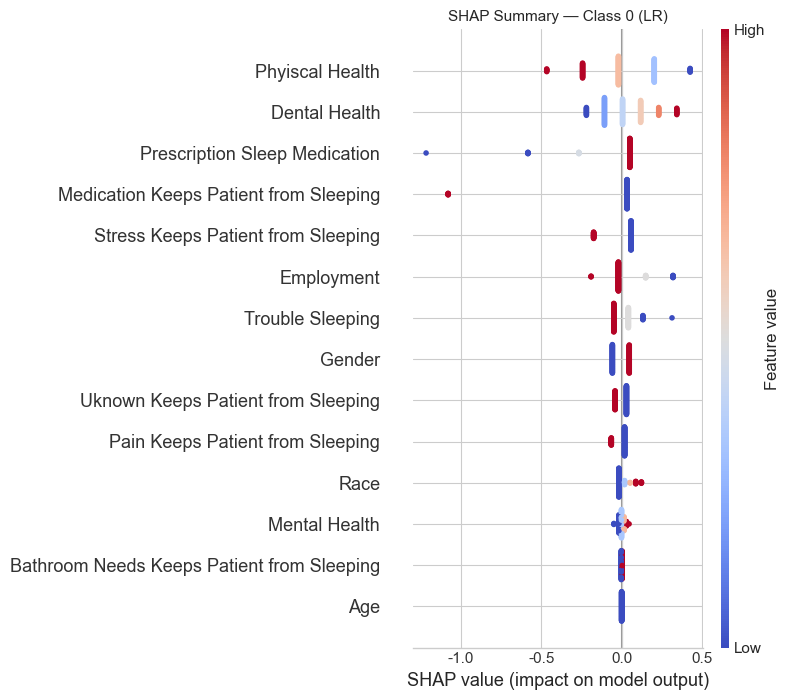

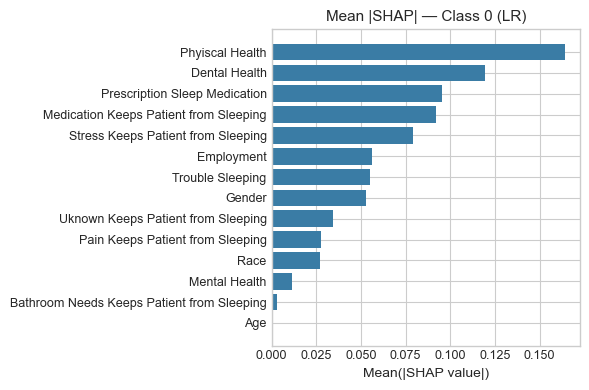


🎨 绘制 Class 1 的 SHAP Summary 图...


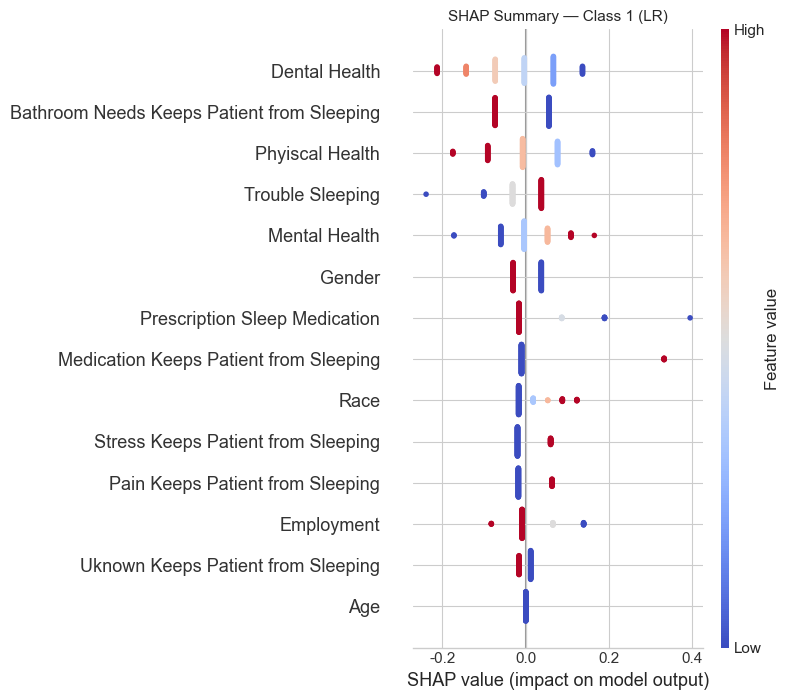

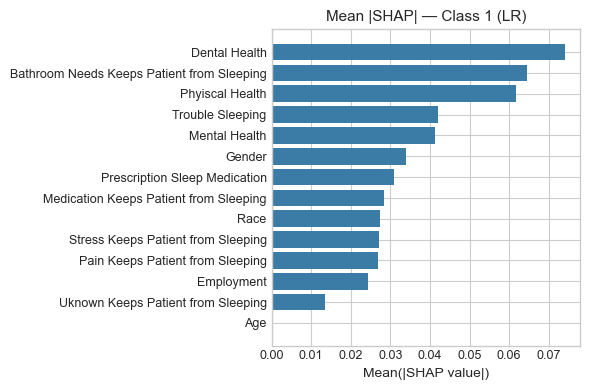


🎨 绘制 Class 2 的 SHAP Summary 图...


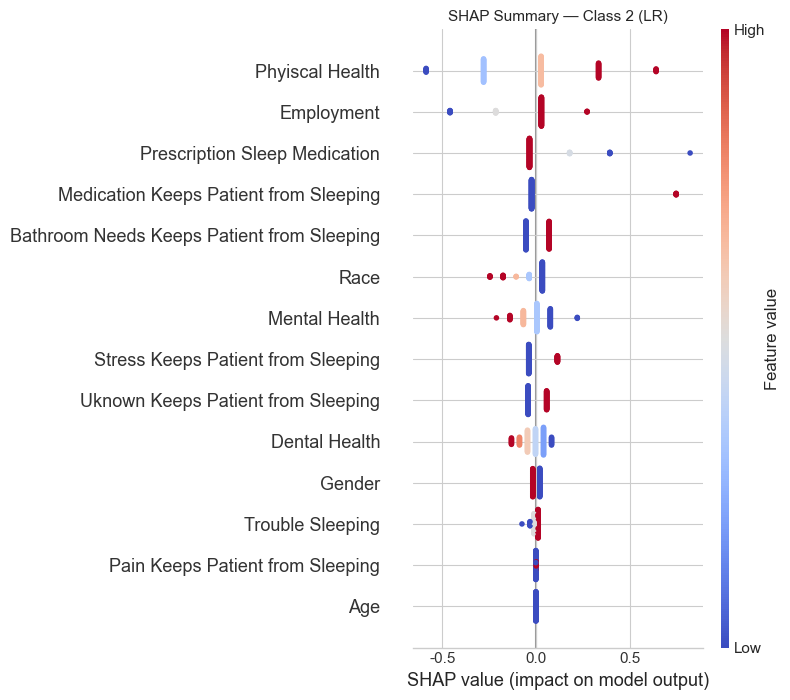

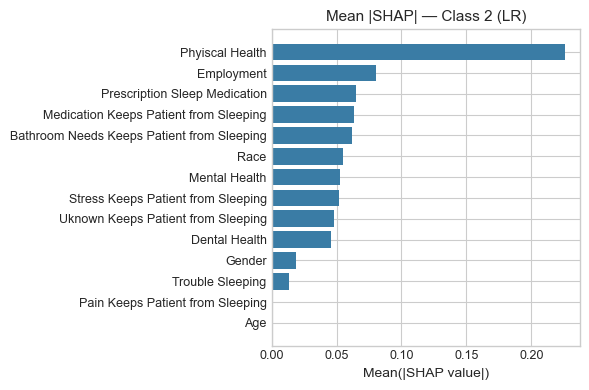


✅ 所有类别 SHAP 可视化完成！
📈 已保存全局 SHAP 重要性表格到 C:\Users\20855\output\SHAP_mean_importance_ds3.csv


In [6]:
# # 代码块6：SHAP 全局特征解释（多分类模型，数据集3）
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ===== 检查前置变量 =====
for v in ["final_pipe", "final_name", "X_train", "X_test", "selected_features", "OUTPUT_DIR"]:
    assert v in locals(), f"变量 {v} 不存在，请先运行前面代码。"

# ===== 提取模型与数据 =====
model = final_pipe.named_steps["clf"]
pre = final_pipe.named_steps["pre"]
X_plot = X_test[selected_features]

# ===== 构建 SHAP 解释器 =====
print("⚙️ 构建 SHAP Explainer...")
explainer = shap.Explainer(model, pre.transform(X_train[selected_features]))
sv = explainer(pre.transform(X_plot))
print(f"✅ SHAP 计算完成: {sv.values.shape}, base_values per class = {explainer.expected_value}")

# ===== 配色方案 =====
cmap = plt.get_cmap("coolwarm")

# ===== 绘制每类的 SHAP 图 =====
n_classes = sv.values.shape[-1] if sv.values.ndim == 3 else 1
for k in range(n_classes):
    print(f"\n🎨 绘制 Class {k} 的 SHAP Summary 图...")

    # 取该类别的 SHAP 值矩阵
    sv_k = sv.values[..., k]  # (n_samples, n_features)
    base_val = explainer.expected_value[k]

    # ---- Summary Plot ----
    plt.figure(figsize=(7, 5))
    shap.summary_plot(
        sv_k, features=X_plot, feature_names=selected_features,
        show=False, cmap=cmap
    )
    plt.title(f"SHAP Summary — Class {k} ({final_name})")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"SHAP_summary_class{k}_ds3.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ---- 平均 |SHAP| 排序条形图 ----
    shap_abs = np.abs(sv_k).mean(axis=0)
    order = np.argsort(shap_abs)[::-1]
    plt.figure(figsize=(6, 4))
    plt.barh(np.array(selected_features)[order], shap_abs[order], color="#3A7CA5")
    plt.gca().invert_yaxis()
    plt.xlabel("Mean(|SHAP value|)")
    plt.title(f"Mean |SHAP| — Class {k} ({final_name})")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"SHAP_bar_meanabs_class{k}_ds3.png", dpi=300, bbox_inches="tight")
    plt.show()

print("\n✅ 所有类别 SHAP 可视化完成！")

# ===== 保存平均 SHAP 重要性（宏平均） =====
if n_classes > 1:
    shap_mean_all = np.abs(sv.values).mean(axis=(0, 2))
else:
    shap_mean_all = np.abs(sv.values).mean(axis=0)
imp_df = pd.DataFrame({
    "Feature": selected_features,
    "Mean|SHAP|": shap_mean_all
}).sort_values("Mean|SHAP|", ascending=False)
imp_df.to_csv(OUTPUT_DIR / "SHAP_mean_importance_ds3.csv", index=False, encoding="utf-8-sig")

print(f"📈 已保存全局 SHAP 重要性表格到 {OUTPUT_DIR / 'SHAP_mean_importance_ds3.csv'}")


In [7]:
# 代码块7：DiCE 反事实（三分类稳定版；数据集3）
import dice_ml, numpy as np, pandas as pd, os
from dice_ml import Dice
from IPython.display import display

for v in ["final_pipe","X","y","X_train","X_test","y_train","y_test","OUTPUT_DIR","TARGET_COL","selected_features","num_cols"]:
    assert v in locals(), f"变量 {v} 不存在，请先运行代码块1~6。"

# 选择三组样本：A=误分类1个，B=正确分类1个，C=误分类另1个
y_pred_test = final_pipe.predict(X_test[selected_features])
mis_idx = np.where(y_pred_test != y_test.values)[0].tolist()
cor_idx = np.where(y_pred_test == y_test.values)[0].tolist()
if len(mis_idx)==0: mis_idx=[0]
if len(cor_idx)==0: cor_idx=[0]

idx_A = mis_idx[0]
idx_C = mis_idx[1] if len(mis_idx)>1 else mis_idx[0]
idx_B = cor_idx[0]

xa, ya_true, ya_pred = X_test.iloc[[idx_A]], int(y_test.iloc[idx_A]), int(y_pred_test[idx_A])
xb, yb_true, yb_pred = X_test.iloc[[idx_B]], int(y_test.iloc[idx_B]), int(y_pred_test[idx_B])
xc, yc_true, yc_pred = X_test.iloc[[idx_C]], int(y_test.iloc[idx_C]), int(y_pred_test[idx_C])

print(f"A: mis idx={idx_A}, true={ya_true}, pred={ya_pred}")
print(f"B: correct idx={idx_B}, true={yb_true}, pred={yb_pred}")
print(f"C: mis idx={idx_C}, true={yc_true}, pred={yc_pred}")

# DiCE 封装
d = dice_ml.Data(
    dataframe=pd.concat([X, y.rename(TARGET_COL)], axis=1),
    continuous_features=[c for c in X.columns if c in X.select_dtypes(include=[np.number]).columns],
    outcome_name=TARGET_COL
)
m = dice_ml.Model(model=final_pipe, backend="sklearn")
dice = Dice(d, m, method="random")

# 关键三列（优先数值列，不足用任意列补）
key_cols = [c for c in num_cols if c in X.columns][:3]
if len(key_cols)<3:
    for c in X.columns:
        if c not in key_cols: key_cols.append(c)
        if len(key_cols)>=3: break
key_cols = key_cols[:3]
print("关键列用于表格展示：", key_cols)

def arrow(a, b, ndigits=3, eps=1e-4):
    if pd.isna(a) and pd.isna(b): return "NA"
    if pd.isna(a) or pd.isna(b): return f"{a} → {b}"
    try:
        af, bf = float(a), float(b)
        return f"{af:.{ndigits}f}" if abs(af-bf)<eps else f"{af:.{ndigits}f} → {bf:.{ndigits}f}"
    except Exception:
        return f"{a} → {b}" if str(a)!=str(b) else str(a)

def has_change_on_keys(x_orig: pd.Series, row: pd.Series, cols, eps=1e-4):
    for c in cols:
        try:
            a,b = float(x_orig[c]), float(row[c])
            if abs(a-b)>=eps: return True
        except Exception:
            if str(x_orig[c])!=str(row[c]): return True
    return False

def cf_candidates(x_query, desired, n_target):
    total = max(n_target*3, n_target+5)
    exp = dice.generate_counterfactuals(x_query, total_CFs=total, desired_class=desired)
    return exp.cf_examples_list[0].final_cfs_df.reset_index(drop=True)

def make_table(x_orig: pd.Series, cf_df: pd.DataFrame, cols, n_keep:int, label_name:str):
    mask = [has_change_on_keys(x_orig, row, cols) for _,row in cf_df.iterrows()]
    cff = cf_df[np.array(mask)].reset_index(drop=True)
    if len(cff)>n_keep: cff = cff.iloc[:n_keep].copy()
    rows = []
    pred_orig = int(final_pipe.predict(pd.DataFrame([x_orig]))[0])
    for i, row in cff.iterrows():
        x_cf = pd.DataFrame([row[X.columns] if all(c in row.index for c in X.columns) else row])
        pred_cf = int(final_pipe.predict(x_cf)[0])
        rec = {"Serial No": i+1}
        for c in cols: rec[c] = arrow(x_orig[c], row[c])
        rec[label_name] = f"{pred_orig} → {pred_cf}"
        rows.append(rec)
    return pd.DataFrame(rows)

# A: 误分类 → 真实类（10）
cfA = cf_candidates(xa, desired=ya_true, n_target=10)
tableA = make_table(xa.iloc[0], cfA, key_cols, 10, TARGET_COL)

# B: 正确分类 → 改成“另一个不同类”（5）
other_class = (yb_pred + 1) % len(np.unique(y))  # 任意不同类
cfB = cf_candidates(xb, desired=other_class, n_target=5)
tableB = make_table(xb.iloc[0], cfB, key_cols, 5, TARGET_COL)

# C: 另一误分类 → 真实类（10）
cfC = cf_candidates(xc, desired=yc_true, n_target=10)
tableC = make_table(xc.iloc[0], cfC, key_cols, 10, TARGET_COL)

print("\n=== TableA：Error Class → True Class（10）==="); display(tableA)
print("\n=== TableB：Correct Class → Other Class（5）==="); display(tableB)
print("\n=== TableC：Another Error Class → 真实（10）==="); display(tableC)

tableA.to_csv(OUTPUT_DIR/"tableA_counterfactuals_ds3.csv", index=False, encoding="utf-8-sig")
tableB.to_csv(OUTPUT_DIR/"tableB_counterfactuals_ds3.csv", index=False, encoding="utf-8-sig")
tableC.to_csv(OUTPUT_DIR/"tableC_counterfactuals_ds3.csv", index=False, encoding="utf-8-sig")
print("✅ 已保存 A/B/C 三个 CSV。")


A: mis idx=2, true=0, pred=1
B: correct idx=0, true=1, pred=1
C: mis idx=3, true=2, pred=1
关键列用于表格展示： ['Age', 'Phyiscal Health', 'Mental Health']


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


=== 表A：误分类 → 真实类（10）===


,Serial No,Age,Phyiscal Health,Mental Health,Number of Doctors Visited
0,1,2.000,2.000 → 0.000,2.000,1 → 0
1,2,2.000,2.000 → 0.000,2.000 → 1.000,1 → 0
2,3,2.000,2.000,2.000 → 3.000,1 → 0
3,4,2.000,2.000,2.000 → 3.000,1 → 0
4,5,2.000,2.000,2.000 → 0.000,1 → 0
5,6,2.000,2.000 → -1.000,2.000,1 → 0
6,7,2.000,2.000,2.000 → 0.000,1 → 0
7,8,2.000,2.000 → 0.000,2.000,1 → 0
8,9,2.000,2.000 → 1.000,2.000,1 → 0
9,10,2.000,2.000 → 0.000,2.000,1 → 0



=== 表B：正确分类 → 其他类（5）===


,Serial No,Age,Phyiscal Health,Mental Health,Number of Doctors Visited
0,1,2.000,1.000 → 5.000,1.000,1 → 2
1,2,2.000,1.000 → 5.000,1.000 → 0.000,1 → 2
2,3,2.000,1.000 → 5.000,1.000,1 → 2
3,4,2.000,1.000 → 5.000,1.000,1 → 2
4,5,2.000,1.000 → 5.000,1.000,1 → 2



=== 表C：另一误分类 → 真实类（10）===


,Serial No,Age,Phyiscal Health,Mental Health,Number of Doctors Visited
0,1,2.000,3.000 → 4.000,2.000,1 → 2
1,2,2.000,3.000,2.000 → 0.000,1 → 2
2,3,2.000,3.000,2.000 → -1.000,1 → 2
3,4,2.000,3.000 → 5.000,2.000,1 → 2
4,5,2.000,3.000 → 5.000,2.000,1 → 2
5,6,2.000,3.000 → 5.000,2.000,1 → 2
6,7,2.000,3.000,2.000 → 1.000,1 → 2
7,8,2.000,3.000 → 5.000,2.000,1 → 2
8,9,2.000,3.000 → 4.000,2.000,1 → 2
9,10,2.000,3.000 → 4.000,2.000,1 → 2


✅ 已保存 A/B/C 三个 CSV。


In [9]:
# 代码块8：持久化 
import json, joblib, numpy as np, pandas as pd
from pathlib import Path

# ===== 检查前置变量 =====
for v in ["final_pipe","selected_features","X_train","num_cols","cat_cols","TARGET_COL","OUTPUT_DIR","RANDOM_STATE"]:
    assert v in locals(), f"变量 {v} 不存在，请先运行代码块1~7。"

# 确保 PROJECT_ROOT 已定义（如果未定义，从 OUTPUT_DIR 推断）
if "PROJECT_ROOT" not in locals():
    PROJECT_ROOT = OUTPUT_DIR.parent  # 从 OUTPUT_DIR 推断项目根目录

ART_DIR = OUTPUT_DIR/"artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# ===== 保存模型 =====
joblib.dump(final_pipe, ART_DIR/"final_pipe_ds3.joblib")

# ===== 生成元数据 =====
classes = sorted(pd.Series(df[TARGET_COL]*0 + y).unique())
meta = {
    "target_col": TARGET_COL,
    "selected_features": selected_features,
    "num_cols": [c for c in selected_features if c in num_cols],
    "cat_cols": [c for c in selected_features if c in cat_cols],
    "classes": classes
}

# 类别候选值、数值范围
cat_values = {
    c: sorted([str(x) for x in pd.Series(X_train[c]).dropna().unique().tolist()][:50])
    for c in meta["cat_cols"]
}

num_ranges = {}
for c in meta["num_cols"]:
    s = pd.to_numeric(X_train[c], errors="coerce").dropna()
    num_ranges[c] = {
        "min": float(np.percentile(s,1)) if len(s)>0 else 0.0,
        "max": float(np.percentile(s,99)) if len(s)>0 else 1.0,
        "mean": float(s.mean()) if len(s)>0 else 0.0
    }

meta["cat_values"] = cat_values
meta["num_ranges"] = num_ranges

# ---- 修复 int64/json 序列化 ----
def np_to_py(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, (np.ndarray, list, tuple)):
        return [np_to_py(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: np_to_py(v) for k, v in obj.items()}
    else:
        return obj

meta_py = np_to_py(meta)
with open(ART_DIR/"meta_ds3.json","w",encoding="utf-8") as f:
    json.dump(meta_py, f, ensure_ascii=False, indent=2)

# ===== 背景样本 =====
bg = X_train[selected_features].sample(min(200, len(X_train)), random_state=RANDOM_STATE)
bg.to_csv(ART_DIR/"bg_sample_ds3.csv", index=False, encoding="utf-8-sig")

print("✅ 已保存模型与元数据到：", ART_DIR)



✅ 已保存模型与元数据到： C:\Users\20855\output\artifacts
